# Classifiers - busy vs relaxed difficulty - no TFv1
Exploring different classifiers with different autoencoders. No contractive autoencoder because it needs TFv1 compatibility.

#### Table of contents:  

autoencoders:  
[Undercomplete Autoencoder](#Undercomplete-Autoencoder)  
[Sparse Autoencoder](#Sparse-Autoencoder)  
[Deep Autoencoder](#Deep-Autoencoder)  

classifiers:  
[Simple dense layer](#Simple-dense-layer)  
[LSTM-based classifier](#LSTM-based-classifier)  
[kNN](#kNN)  
[SVC](#SVC)  
[Random Forest](#Random-Forest)  
[XGBoost](#XGBoost)  

In [1]:
import datareader # made by the previous author for reading the collected data
import dataextractor # same as above
import pandas
import numpy as np
import tensorflow as tf

from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Input
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Conv1D, MaxPooling1D
# required for the contractive autoencoder
import tensorflow.keras.backend as K
import json
from datetime import datetime

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import RandomizedSearchCV

import warnings

import talos
from talos.utils import lr_normalizer

from tensorflow import keras
from tensorflow.keras import layers, regularizers
import matplotlib.pyplot as plt

tf.keras.backend.set_floatx('float32') # call this, to set keras to use float32 to avoid a warning message
metrics = ['accuracy']#,
#            keras.metrics.TruePositives(),
#            keras.metrics.FalsePositives(),
#            keras.metrics.TrueNegatives(),
#            keras.metrics.FalseNegatives()]

In [2]:
# from https://github.com/ageron/handson-ml/blob/master/extra_tensorflow_reproducibility.ipynb
config = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                        inter_op_parallelism_threads=1)

with tf.compat.v1.Session(config=config) as sess:
    #... this will run single threaded
    pass

In [3]:
import random

random.seed(1)
np.random.seed(4)
tf.random.set_seed(2)

In [4]:
# Start the notebook in the terminal with "PYTHONHASHSEED=0 jupyter notebook" 
# or in anaconda "set PYTHONHASHSEED=0" then start jupyter notebook
import os
if os.environ.get("PYTHONHASHSEED") != "0":
    raise Exception("You must set PYTHONHASHSEED=0 when starting the Jupyter server to get reproducible results.")

This is modfied original author's code for reading data:

In [5]:
def model_train(model, x_train, y_train, batch_size, epochs, x_valid, y_valid, x_test, y_test):
    """Train model with the given training, validation, and test set, with appropriate batch size and # epochs."""
    epoch_data = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_valid, y_valid), verbose=0)
    score = model.evaluate(x_test, y_test, batch_size=batch_size, verbose=0)
    acc = score[1]
    score = score[0]
    return score, acc, epoch_data


In [6]:
def get_task_complexities_timeframes_br_hb(path, ident, seconds):
    """Returns raw data along with task complexity class.
    TODO: join functions. Add parameter to choose different task types and complexities"""

    dataread = datareader.DataReader(path, ident)  # initialize path to data
    data = dataread.read_grc_data()  # read from files
    samp_rate = int(round(len(data[1]) / max(data[0])))
    cog_res = dataread.read_cognitive_load_study(str(ident) + '-primary-extract.txt')

    tasks_data = np.empty((0, seconds*samp_rate))
    tasks_y = np.empty((0, 1))
    breathing = np.empty((0,12))
    heartbeat = np.empty((0,10))

    busy_n = dataread.get_data_task_timestamps(return_indexes=True)
    
    for i in cog_res['task_number']:
        task_num_table = i - 225  # 0 - 17
        tmp_tasks_data = np.empty((0, seconds*samp_rate))
        tmp_tasks_y = np.empty((0, 1))
        tmp_breathing = np.empty((0,12))
        tmp_heartbeat = np.empty((0,10))
        
        ### task complexity classification
        if cog_res['task_complexity'][task_num_table] == 'medium':
            continue
        # if cog_res['task_label'][task_num_table] == 'FA' or cog_res['task_label'][task_num_table] == 'HP':
        #     continue
#         if cog_res['task_label'][task_num_table] != 'NC':
#             continue
            
        map_compl = {
            'low': 0,
            'medium': 2,
            'high': 1
        }
        for j in range(10):
            new_end = int(busy_n[task_num_table][1] - j * samp_rate)
            new_start = int(new_end - samp_rate*30)
            dataextract = dataextractor.DataExtractor(data[0][new_start:new_end],
                                                      data[1][new_start:new_end], samp_rate)
            # get extracted features for breathing
            tmpBR = dataextract.extract_from_breathing_time(data[0][new_start:new_end],
                                                                 data[1][new_start:new_end])
            #get extracted features for heartbeat
            tmpHB = dataextract.extract_from_heartbeat_time(data[0][new_start:new_end],
                                                                 data[1][new_start:new_end])
            
            try:
                
                tmp_tasks_data = np.vstack((tmp_tasks_data, dataextract.y[-samp_rate * seconds:]))
                tmp_tasks_y = np.vstack((tmp_tasks_y, map_compl.get(cog_res['task_complexity'][task_num_table])))

                tmp_breathing = np.vstack((tmp_breathing, tmpBR.to_numpy(dtype='float64', na_value=0)[0][:-1]))
                tmp_heartbeat = np.vstack((tmp_heartbeat, tmpHB.to_numpy(dtype='float64', na_value=0)[0][:-1]))
                
            except ValueError:
#                 print(ident)
                continue

            tasks_data = np.vstack((tasks_data, dataextract.y))
            tasks_y = np.vstack((tasks_y, map_compl.get(cog_res['task_complexity'][task_num_table])))
            breathing = np.vstack((breathing, tmpBR.to_numpy(dtype='float64', na_value=0)[0][:-1]))
            heartbeat = np.vstack((heartbeat, tmpHB.to_numpy(dtype='float64', na_value=0)[0][:-1]))
            
    return tasks_data, tasks_y, breathing, heartbeat

In [7]:
def get_data_from_idents_br_hb(path, idents, seconds):
    """Go through all user data and take out windows of only <seconds> long time frames,
    along with the given class (from 'divide_each_task' function).
    """
    samp_rate = 43  # hard-coded sample rate
    data, ys = np.empty((0, samp_rate*seconds)), np.empty((0, 1))
    brs = np.empty((0,12))
    hbs = np.empty((0,10))
    combined = np.empty((0,22))
    
    # was gettign some weird warnings; stack overflow said to ignore them
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        for i in idents:
            #x, y, br, hb = get_busy_vs_relax_timeframes_br_hb(path, i, seconds) # either 'get_busy_vs_relax_timeframes',
            # get_engagement_increase_vs_decrease_timeframes, get_task_complexities_timeframes or get_TLX_timeframes
            x, y, br, hb = get_task_complexities_timeframes_br_hb(path, i, seconds)
            
            data = np.vstack((data, x))
            ys = np.vstack((ys, y))
            brs = np.vstack((brs, br))
            hbs = np.vstack((hbs, hb))
        combined = np.hstack((brs,hbs))
    
    return data, ys, brs, hbs, combined

In [8]:
def scale_data(x, standardScaler=True, minMaxScaler=True):
    
    if standardScaler:
        # Scale with standard scaler
        sscaler = StandardScaler()
        sscaler.fit(x)
        x = sscaler.transform(x)

    if minMaxScaler:
        # Scale with MinMax to range [0,1]
        mmscaler = MinMaxScaler((0,1))
        mmscaler.fit(x)
        x = mmscaler.transform(x)
    
    return x

In [9]:
# Accs is a dictionary which holds 1d arrays of accuracies in each key
# except the key 'test id' which holds strings of the id which yielded the coresponding accuracies
def print_accs_stats(accs):
    
    printDict = {}
    # loop over each key
    for key in accs:
    
        if (key == 'test id'):
            # skip calculating ids
            continue
        printDict[key] = {}
        tmpDict = printDict[key]
        # calculate and print some statistics
        tmpDict['min'] = np.min(accs[key])
        tmpDict['max'] = np.max(accs[key])
        tmpDict['mean'] = np.mean(accs[key])
        tmpDict['median'] = np.median(accs[key])
    
    print(pandas.DataFrame.from_dict(printDict).to_string())

In [10]:
def clear_session_and_set_seeds():
    # clear session and set seeds again
    K.clear_session()
    random.seed(1)
    np.random.seed(4)
    tf.random.set_seed(2)

## Prepare data

Initialize variables:

In [11]:
# initialize a dictionary to store accuracies for comparison
accuracies = {}

# used for reading the data into an array
seconds = 30  # time window length
samp_rate = 43  # hard-coded sample rate
phase_shape = np.empty((0, samp_rate*seconds))
y_shape = np.empty((0, 1))
breathing_shape = np.empty((0,12))
heartbeat_shape = np.empty((0,10))
combined_shape = np.empty((0,22))
idents = ['2gu87', 'iz2ps', '1mpau', '7dwjy', '7swyk', '94mnx', 'bd47a', 'c24ur', 'ctsax', 'dkhty', 'e4gay',
              'ef5rq', 'f1gjp', 'hpbxa', 'pmyfl', 'r89k1', 'tn4vl', 'td5pr', 'gyqu9', 'fzchw', 'l53hg', '3n2f9',
              '62i9y']
path = '../../../StudyData/'


# change to len(idents) at the end to use all the data
n = len(idents)

In [12]:
# load all phase data to use for training autoencoders
phase_all_train = get_data_from_idents_br_hb(path, idents[:-2], seconds)[0]
phase_all_train = scale_data(phase_all_train)

# load all phase data to use for training autoencoders
phase_all_valid = get_data_from_idents_br_hb(path, idents[-2:], seconds)[0]
phase_all_valid = scale_data(phase_all_valid)

In [13]:
# Holds all the data so it doesnt have to be read from file each time
data_dict = {}

Fill the data dictionary:

In [14]:
for ident in idents:
    
    # initialize ident in 
    data_dict[ident] = {}
    tmpDataDict = data_dict[ident]
    
    # read data
    phase, y, breathing, heartbeat, combined = get_data_from_idents_br_hb(path, [ident], seconds)
    
    # load data into dictionary
    tmpDataDict['phase'] = phase
    tmpDataDict['y'] = y
    tmpDataDict['breathing'] = breathing
    tmpDataDict['heartbeat'] = heartbeat
    tmpDataDict['combined'] = combined

## Autoencoders  
Train autoencoders to save their encoded representations in the data dictionary:

In [15]:
# AE Training params
batch_size = 256
epochs = 500
encoding_dim = 60
ae_encoded_shape = np.empty((0,encoding_dim))

In [16]:
def compare_plot_n(data1, data2, plot_n=12):
    
    #plot data1 values
    plt.figure()
    plt.figure(figsize=(20, 4))
    for i in range(plot_n):
        plt.subplot(plot_n/5, 6, i+1)
        plt.plot(data1[i])

    #plot data2 values
    plt.figure()
    plt.figure(figsize=(20, 4))
    for i in range(plot_n):
        plt.subplot(plot_n/5, 6, i+1)
        plt.plot(data2[i])

#### Undercomplete Autoencoder  
from https://blog.keras.io/building-autoencoders-in-keras.html

In [17]:
def undercomplete_ae(x, encoding_dim=64, encoded_as_model=False):
    # Simplest possible autoencoder from https://blog.keras.io/building-autoencoders-in-keras.html

    # this is our input placeholder
    input_data = Input(shape=x[0].shape, name="input")
    dropout = Dropout(0, name="dropout", seed=42)(input_data)
    # "encoded" is the encoded representation of the input
    encoded = Dense(encoding_dim, activation='relu', name="encoded")(dropout)
    
    # "decoded" is the lossy reconstruction of the input
    decoded = Dense(x[0].shape[0], activation='sigmoid', name="decoded")(encoded)

    autoencoder = Model(input_data, decoded)
    
    # compile the model
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=metrics)
    
    # if return encoder in the encoded variable
    if encoded_as_model:
        encoded = Model(input_data, encoded)
    
    return autoencoder, encoded

Train autoencoder on data:

In [18]:
clear_session_and_set_seeds()
uc_ae, uc_enc = undercomplete_ae(phase_all_train, encoding_dim=encoding_dim, encoded_as_model=True)
uc_ae.fit(phase_all_train, phase_all_train,
          validation_data=(phase_all_valid, phase_all_valid),
          batch_size=batch_size,
          shuffle=True,
          epochs=epochs,
          verbose=0)

Plot some reconstructions to compare:

<Figure size 432x288 with 0 Axes>

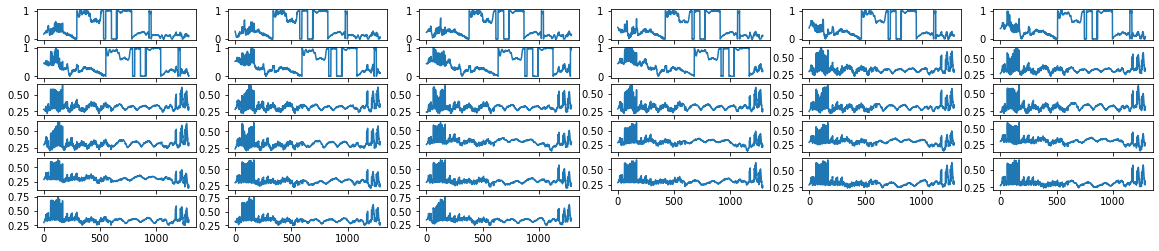

<Figure size 432x288 with 0 Axes>

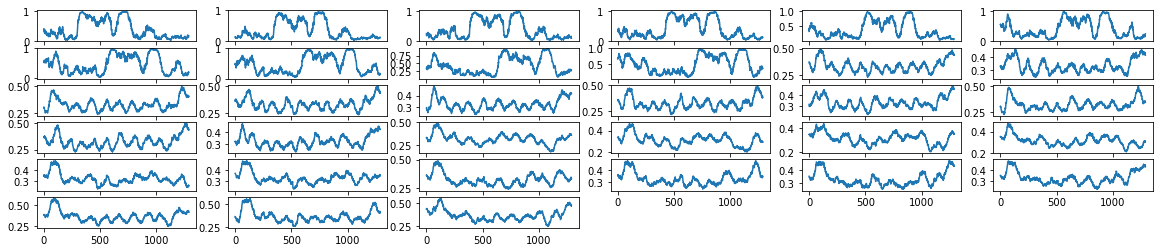

In [19]:
data2 = uc_ae.predict(phase_all_valid)
compare_plot_n(phase_all_valid, data2, 33)

<Figure size 432x288 with 0 Axes>

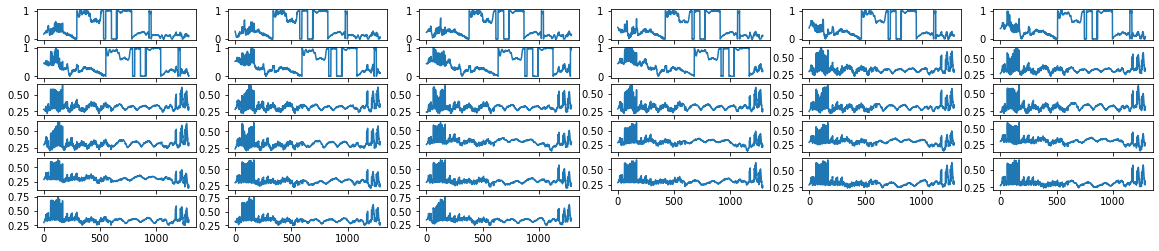

<Figure size 432x288 with 0 Axes>

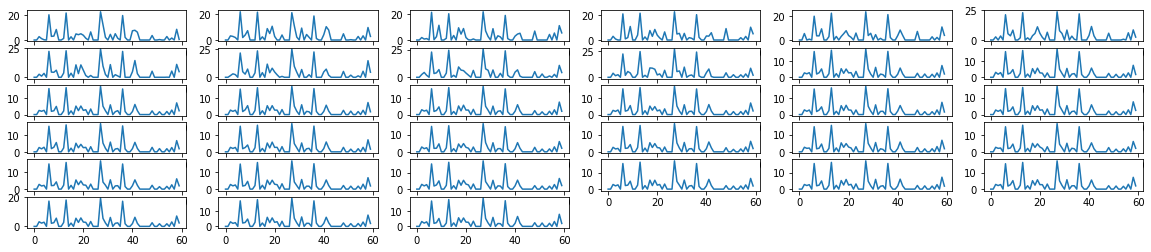

In [20]:
data2 = uc_enc.predict(phase_all_valid)
compare_plot_n(phase_all_valid, data2, 33)

In [21]:
np.sum(np.mean(data2, axis=0) < 0.1)

27

Store the encoded representations in the data dictionary:

In [22]:
for ident in data_dict:
    
    tmpDataDict = data_dict[ident]
    
    # read data
    phase = tmpDataDict['phase']
    
    uc_data = uc_enc.predict(phase)
    
    # load data into dictionary
    tmpDataDict['undercomplete_encoded'] = uc_data

#### Sparse Autoencoder  
from https://blog.keras.io/building-autoencoders-in-keras.html

In [23]:
def sparse_ae(x, encoding_dim=64, encoded_as_model=False):
    # Simplest possible autoencoder from https://blog.keras.io/building-autoencoders-in-keras.html

    # this is our input placeholder
    input_data = Input(shape=x[0].shape, name="input")
    dropout = Dropout(0.25, name="dropout", seed=42) (input_data)
    # "encoded" is the encoded representation of the input
    # add a sparsity constraint
    encoded = Dense(encoding_dim, activation='relu', name="encoded",
                    activity_regularizer=regularizers.l1(10e-5))(dropout)
    
    # "decoded" is the lossy reconstruction of the input
    decoded = Dense(x[0].shape[0], activation='sigmoid', name="decoded")(encoded)

    # this model maps an input to its reconstruction
    autoencoder = Model(input_data, decoded, name="sparse_ae")
    
    # compile the model
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=metrics)
    
    # if return encoder in the encoded variable
    if encoded_as_model:
        encoded = Model(input_data, encoded)
    
    return autoencoder, encoded

Train autoencoder on data:

In [24]:
clear_session_and_set_seeds()
sp_ae, sp_enc = sparse_ae(phase_all_train, encoding_dim=encoding_dim, encoded_as_model=True)
sp_ae.fit(phase_all_train, phase_all_train,
          validation_data=(phase_all_valid, phase_all_valid),
          batch_size=batch_size,
          shuffle=True,
          epochs=epochs,
          verbose=0)

Plot some reconstructions to compare:

<Figure size 432x288 with 0 Axes>

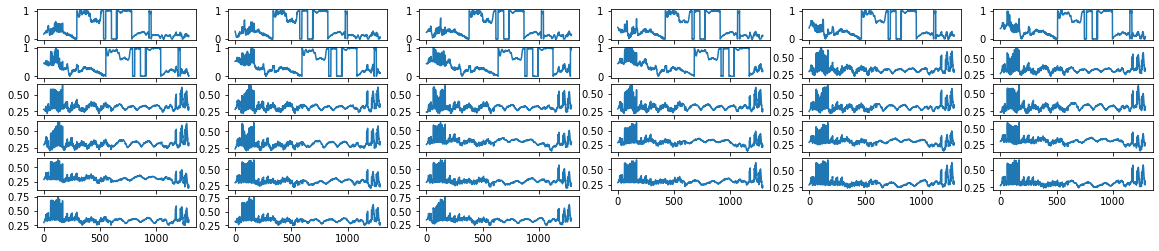

<Figure size 432x288 with 0 Axes>

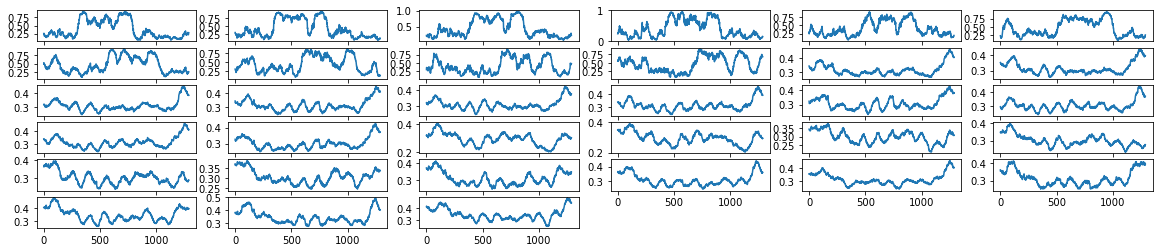

In [25]:
data2 = sp_ae.predict(phase_all_valid)
compare_plot_n(phase_all_valid, data2, 33)

<Figure size 432x288 with 0 Axes>

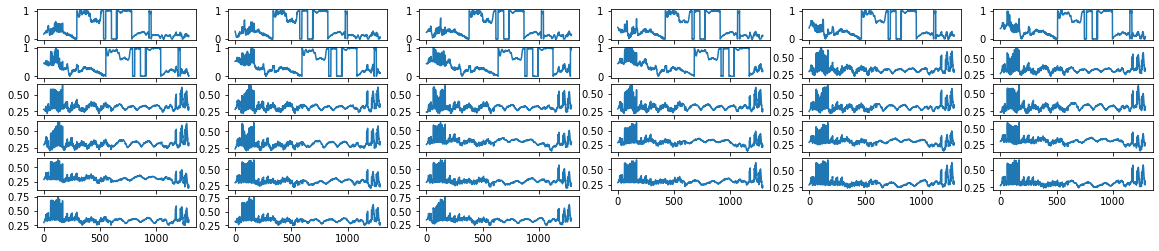

<Figure size 432x288 with 0 Axes>

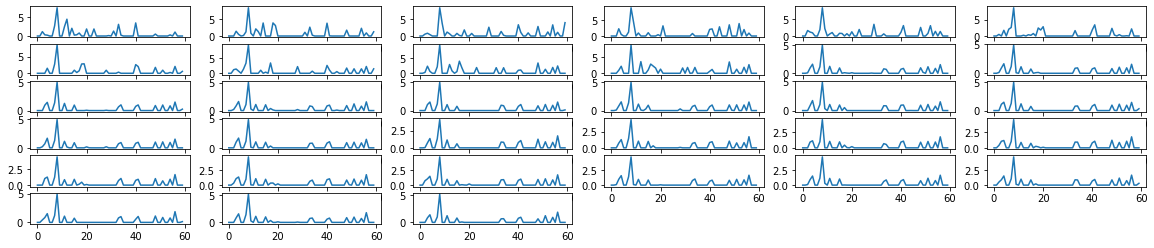

In [26]:
data2 = sp_enc.predict(phase_all_valid)
compare_plot_n(phase_all_valid, data2, 33)

In [27]:
print(np.sum(np.mean(data2, axis=0) < 0.1))
np.mean(data2, axis=0)

34


array([0.        , 0.        , 0.24021606, 0.9446423 , 1.4212924 ,
       0.        , 0.08769596, 1.1894336 , 4.622529  , 0.1882823 ,
       0.        , 1.02757   , 0.18651909, 0.04259058, 0.07252739,
       0.89860386, 0.0753941 , 0.24074088, 0.21980967, 0.05144058,
       0.19397965, 0.11286275, 0.        , 0.0607564 , 0.        ,
       0.        , 0.        , 0.        , 0.13506109, 0.07224909,
       0.        , 0.10789548, 0.        , 0.828604  , 0.85110724,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.9082758 , 1.0456545 , 0.        , 0.        , 0.12273243,
       0.        , 0.        , 0.        , 0.9997674 , 0.14627917,
       0.        , 1.0111948 , 0.06054812, 0.        , 0.94475263,
       0.06415804, 1.4387327 , 0.        , 0.        , 0.12036373],
      dtype=float32)

Store the encoded representations in the data dictionary:

In [28]:
for ident in data_dict:
    
    tmpDataDict = data_dict[ident]
    
    # read data
    phase = tmpDataDict['phase']
    
    sp_data = sp_enc.predict(phase)
    
    # load data into dictionary
    tmpDataDict['sparse_encoded'] = sp_data

#### Deep Autoencoder  
from https://blog.keras.io/building-autoencoders-in-keras.html

In [29]:
def deep_ae(x, enc_layers=[512,256], encoding_dim=64, dec_layers=[256,512], encoded_as_model=False):
    # From https://www.tensorflow.org/guide/keras/functional#use_the_same_graph_of_layers_to_define_multiple_models
    input_data = keras.Input(shape=x[0].shape, name="normalized_signal")
    model = Dropout(0.25, name="dropout", autocast=False, seed=42)(input_data)
    for i in enumerate(enc_layers):
        model = Dense(i[1], activation="relu", name="dense_enc_" + str(i[0]+1))(model)
    encoded_output = Dense(encoding_dim, activation="relu", name="encoded_signal")(model)

    encoded = encoded_output

    model = layers.Dense(dec_layers[0], activation="sigmoid", name="dense_dec_1")(encoded_output)
    for i in enumerate(dec_layers[1:]):
        model = Dense(i[1], activation="sigmoid", name="dense_dec_" + str(i[0]+2))(model)
    decoded_output = Dense(x[0].shape[0], activation="sigmoid", name="reconstructed_signal")(model)
    
    autoencoder = Model(input_data, decoded_output, name="autoencoder")
    
    # compile the model
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=metrics)
    
    # if return encoder in the encoded variable
    if encoded_as_model:
        encoded = Model(input_data, encoded)

    return autoencoder, encoded

Train autoencoder on data:

In [30]:
clear_session_and_set_seeds()
de_ae, de_enc = deep_ae(phase_all_train, encoding_dim=encoding_dim, encoded_as_model=True)
de_ae.fit(phase_all_train, phase_all_train,
          validation_data=(phase_all_valid, phase_all_valid),
          batch_size=batch_size,
          shuffle=True,
          epochs=epochs,
          verbose=0)

Plot some reconstructions to compare:

<Figure size 432x288 with 0 Axes>

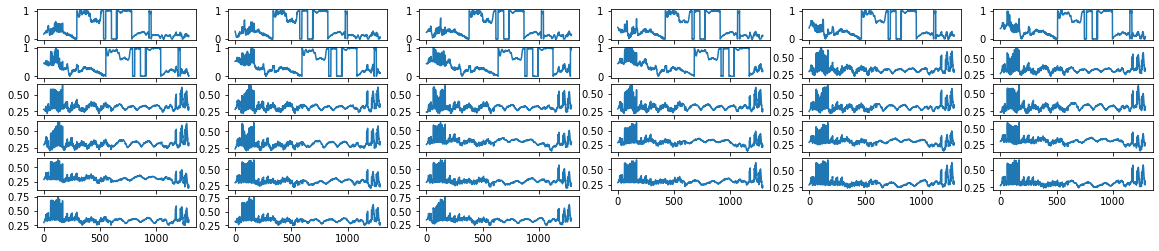

<Figure size 432x288 with 0 Axes>

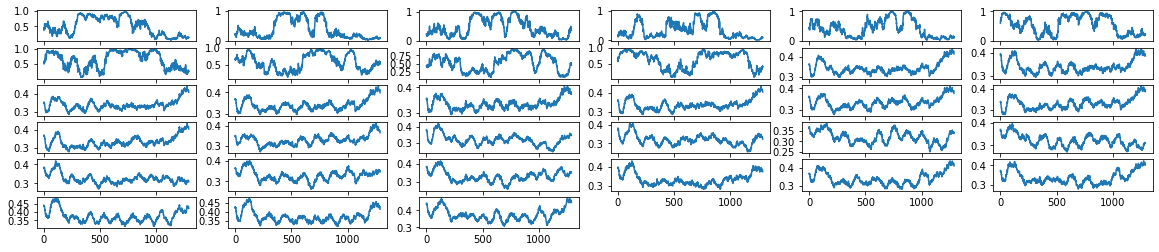

In [31]:
data2 = de_ae.predict(phase_all_valid)
compare_plot_n(phase_all_valid, data2, 33)

<Figure size 432x288 with 0 Axes>

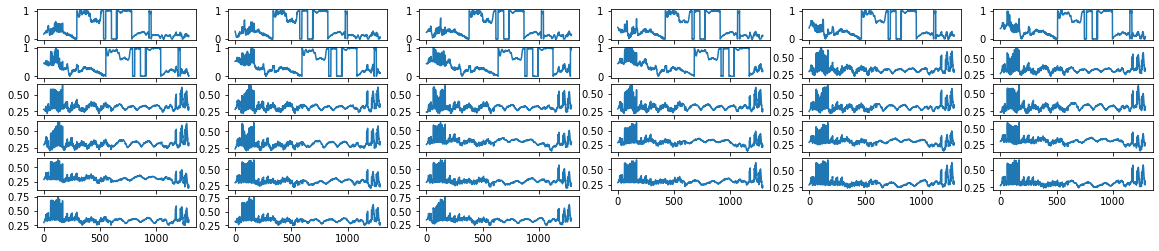

<Figure size 432x288 with 0 Axes>

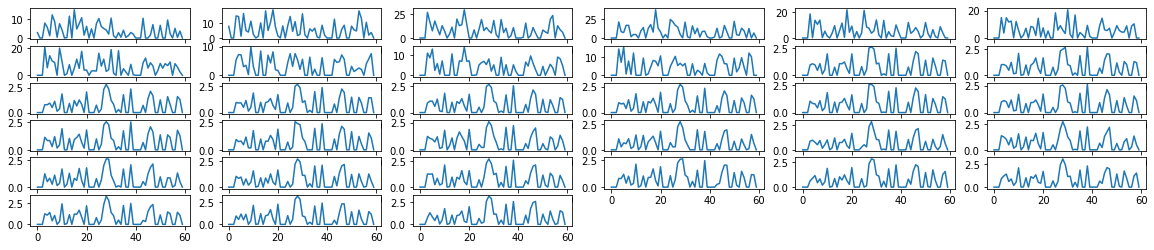

In [32]:
data2 = de_enc.predict(phase_all_valid)
compare_plot_n(phase_all_valid, data2, 33)

In [33]:
print(np.sum(np.mean(data2, axis=0) < 0.1))
np.mean(data2, axis=0)

16


array([6.1699901e-02, 0.0000000e+00, 4.0794806e-05, 1.7533737e+00,
       1.4072968e+00, 1.5167642e+00, 1.1587861e+00, 1.4541613e+00,
       4.0582380e-01, 1.0528605e+00, 1.8741534e+00, 9.2035607e-02,
       3.2791153e-01, 1.5190145e+00, 5.4748610e-02, 1.4971544e+00,
       1.5158588e+00, 1.6490062e+00, 1.6477290e+00, 6.7124867e-01,
       1.8632196e+00, 0.0000000e+00, 2.6781625e-01, 1.4820152e-02,
       1.2774999e+00, 8.2808614e-01, 9.8617333e-01, 2.5051959e+00,
       2.4824672e+00, 2.0890393e+00, 1.7945205e+00, 9.8118871e-01,
       7.0693836e-02, 1.0826586e+00, 8.7123282e-02, 1.8714176e+00,
       5.7588816e-02, 1.0256466e-01, 2.6464975e+00, 2.4034919e-01,
       0.0000000e+00, 0.0000000e+00, 7.0345610e-02, 1.3724387e+00,
       5.6721312e-01, 1.6680031e+00, 2.1242793e+00, 2.0033779e+00,
       0.0000000e+00, 1.0758876e-01, 1.8053000e+00, 3.6440316e-01,
       2.9427856e-01, 2.0246503e+00, 1.3832281e+00, 0.0000000e+00,
       5.7993633e-01, 1.6324160e+00, 1.3695599e+00, 0.0000000e

Store the encoded representations in the data dictionary:

In [34]:
for ident in data_dict:
    
    tmpDataDict = data_dict[ident]
    
    # read data
    phase = tmpDataDict['phase']
    
    de_data = de_enc.predict(phase)
    
    # load data into dictionary
    tmpDataDict['deep_encoded'] = de_data

Helper function to get data from the dictionary:

In [35]:
def get_ident_data_from_dict(idents, data_dict, should_scale_data=True):
    
    # Initialize data variables
    y = y_shape.copy()
    phase = phase_shape.copy()
    breathing = breathing_shape.copy()
    heartbeat = heartbeat_shape.copy()
    combined = combined_shape.copy()
    undercomplete_encoded = ae_encoded_shape.copy()
    sparse_encoded = ae_encoded_shape.copy()
    deep_encoded = ae_encoded_shape.copy()
    
    # Stack data form each ident into the variables
    for tmp_id in idents:
        y = np.vstack((y, data_dict[tmp_id]['y']))
        phase = np.vstack((phase, data_dict[tmp_id]['phase']))
        breathing = np.vstack((breathing, data_dict[tmp_id]['breathing']))
        heartbeat = np.vstack((heartbeat, data_dict[tmp_id]['heartbeat']))
        combined = np.vstack((combined, data_dict[tmp_id]['combined']))
        undercomplete_encoded = np.vstack((undercomplete_encoded, data_dict[tmp_id]['undercomplete_encoded']))
        sparse_encoded = np.vstack((sparse_encoded, data_dict[tmp_id]['sparse_encoded']))
        deep_encoded = np.vstack((deep_encoded, data_dict[tmp_id]['deep_encoded']))
    
    if should_scale_data:
        # Scale each data before returning
        phase = scale_data(phase)
        breathing = scale_data(breathing)
        heartbeat = scale_data(heartbeat)
        combined = scale_data(combined)
        undercomplete_encoded = scale_data(undercomplete_encoded)
        sparse_encoded = scale_data(sparse_encoded)
        deep_encoded = scale_data(deep_encoded)
    
    return y, phase, breathing, heartbeat, combined, undercomplete_encoded, sparse_encoded, deep_encoded

In [36]:
# '62i9y''2gu87''iz2ps'

y_train, phase_train, br_train, hb_train, cmb_train, undercomplete_encoded_train, \
sparse_encoded_train, deep_encoded_train = get_ident_data_from_dict(['62i9y','2gu87'], data_dict)

phase_train2, y_train2, _, _, _ = get_data_from_idents_br_hb(path, ['62i9y','2gu87'], seconds)

phase_train2 = scale_data(phase_train2)

(phase_train == phase_train2).all()

True

## Classifiers

#### Helper loop function definition  
A function that loops over all the data and calls the classifiers with it then stores the returned accuracies.

In [37]:
def helper_loop(classifier_function_train, idents, n=5, num_loops_to_average_over=1, should_scale_data=True):
    #returns a dictionary with accuracies

    # set the variables in the dictionary
    accs = {}
    accs['phase'] = []
    accs['breathing'] = []
    accs['heartbeat'] = []
    accs['combined br hb'] = []
    accs['undercomplete'] = []
    accs['sparse'] = []
    accs['deep'] = []
    accs['test id'] = []
    start_time = datetime.now()

    # leave out person out validation
    for i in range(n):
        
        # print current iteration and time elapsed from start
        print("iteration:", i+1, "of", n, "; time elapsed:", datetime.now()-start_time)

        ## ----- Data preparation:
        validation_idents = [idents[i]]
        test_idents = [idents[i-1]]
        
        train_idents = []
        for ident in idents:
            if (ident not in test_idents) and (ident not in validation_idents):
                train_idents.append(ident)

        # save test id to see which id yielded which accuracies
        accs['test id'].append(test_idents[0])

        # Load train data
        train_data = get_ident_data_from_dict(train_idents, data_dict, should_scale_data)
        y_train = train_data[0]
        
        # Load validation data
        valid_data = get_ident_data_from_dict(validation_idents, data_dict, should_scale_data)
        y_valid = valid_data[0]

        # Load test data
        test_data = get_ident_data_from_dict(test_idents, data_dict, should_scale_data)
        y_test = test_data[0]
        
        data_names_by_index = ['y', 'phase', 'breathing', 'heartbeat',
                                   'combined br hb', 'undercomplete', 'sparse', 'deep']
        
        # Loop over all data that will be used for classification and send it to the classifier
        # index 0 is y so we skip it
        for index in range(1, len(test_data)):
            
            train_x = train_data[index]
            valid_x = valid_data[index]
            test_x = test_data[index]
            
            tmp_acc = []
            data_name = data_names_by_index[index]
            
            for index in range(num_loops_to_average_over):
                clear_session_and_set_seeds()
                curr_acc = classifier_function_train(train_x, y_train, valid_x, y_valid, test_x, y_test, data_name)
                tmp_acc.append(curr_acc)
            
            curr_acc = np.mean(tmp_acc)
            accs[data_name].append(curr_acc)
        

    # Print total time required to run this
    end_time = datetime.now()
    elapsed_time = end_time - start_time
    print("Completed!", "Time elapsed:", elapsed_time)
    
    return accs

#### Simple dense classifier

Define the classifier:

In [38]:
params = {
    'dropout': 0.24,
    'optimizer': 'Adam',
    'hidden_size': 64,
    'loss': 'binary_crossentropy',
    'last_activation': 'sigmoid',
    'activation': 'softmax',
    'batch_size': 256,
    'epochs': 100
}

In [39]:
def dense_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    
    
    # Define the model
    model = Sequential()
    model.add(Dropout(0))
    model.add(Dense(32))
    model.add(Activation('sigmoid'))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    # Compile the model
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=metrics)
    
    # Train the model and return the accuracy
    sc, curr_acc, epoch_data = model_train(model, x_train, y_train, params['batch_size'], params['epochs'],
                                           x_valid, y_valid, x_test, y_test)
    
    return curr_acc

Combine the autoencoders with the classifier: 

In [40]:
accs = helper_loop(dense_train, idents, n)

iteration: 1 of 23 ; time elapsed: 0:00:00
iteration: 2 of 23 ; time elapsed: 0:00:28.194751
iteration: 3 of 23 ; time elapsed: 0:00:56.599713
iteration: 4 of 23 ; time elapsed: 0:01:24.626277
iteration: 5 of 23 ; time elapsed: 0:01:52.849641
iteration: 6 of 23 ; time elapsed: 0:02:21.306731
iteration: 7 of 23 ; time elapsed: 0:02:49.333941
iteration: 8 of 23 ; time elapsed: 0:03:17.453716
iteration: 9 of 23 ; time elapsed: 0:03:45.491129
iteration: 10 of 23 ; time elapsed: 0:04:12.929161
iteration: 11 of 23 ; time elapsed: 0:04:40.478561
iteration: 12 of 23 ; time elapsed: 0:05:08.909083
iteration: 13 of 23 ; time elapsed: 0:05:37.904938
iteration: 14 of 23 ; time elapsed: 0:06:07.002836
iteration: 15 of 23 ; time elapsed: 0:06:35.881684
iteration: 16 of 23 ; time elapsed: 0:07:05.176905
iteration: 17 of 23 ; time elapsed: 0:07:34.253683
iteration: 18 of 23 ; time elapsed: 0:08:02.606592
iteration: 19 of 23 ; time elapsed: 0:08:30.933758
iteration: 20 of 23 ; time elapsed: 0:08:59.009

In [41]:
accuracies['simple_dense'] = accs

In [42]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
pandas.DataFrame.from_dict(accs)

,phase,breathing,heartbeat,combined br hb,undercomplete,sparse,deep,test id
0,0.408333,0.616667,0.541667,0.525000,0.283333,0.366667,0.383333,62i9y
1,0.533333,0.691667,0.558333,0.633333,0.558333,0.525000,0.641667,2gu87
2,0.641667,0.341667,0.533333,0.408333,0.558333,0.508333,0.566667,iz2ps
3,0.533333,0.316667,0.516667,0.291667,0.433333,0.466667,0.441667,1mpau
4,0.425000,0.500000,0.358333,0.508333,0.458333,0.425000,0.341667,7dwjy
5,0.475000,0.383333,0.525000,0.383333,0.450000,0.475000,0.441667,7swyk
6,0.775000,0.566667,0.483333,0.566667,0.558333,0.650000,0.775000,94mnx
7,0.566667,0.491667,0.483333,0.491667,0.366667,0.458333,0.458333,bd47a
8,0.441667,0.441667,0.658333,0.466667,0.533333,0.525000,0.500000,c24ur
9,0.366667,0.425000,0.458333,0.291667,0.525000,0.550000,0.583333,ctsax


In [43]:
# print some statistics for each method
print_accs_stats(accs)

           phase  breathing  heartbeat  combined br hb  undercomplete    sparse      deep
min     0.366667   0.216667   0.316667        0.183333       0.283333  0.308333  0.341667
max     0.775000   0.716667   0.708333        0.741667       0.658333  0.650000  0.775000
mean    0.504348   0.507246   0.504710        0.489130       0.482971  0.490942  0.510145
median  0.491667   0.508333   0.483333        0.516667       0.483333  0.508333  0.533333


#### LSTM-based classifier  
based on the original author's code

In [44]:
params_phase = {
    'kernel_size': 4,
    'filters': 3,
    'strides': 2,
    'pool_size': 2,
    'dropout': 0.09,
    'lstm_output_size': 256,
    'activation': 'relu',
    'last_activation': 'sigmoid',
    'loss': 'binary_crossentropy',
    'optimizer': 'Nadam',
    'batch_size': 64,
    'epochs': 100
}

In [45]:
params_br_hb = {
    'kernel_size': 2,
    'filters': 2,
    'strides': 1,
    'pool_size': 1,
    'dropout': 0.09,
    'lstm_output_size': 4,
    'activation': 'relu',
    'last_activation': 'sigmoid',
    'loss': 'binary_crossentropy',
    'optimizer': 'Nadam',
    'batch_size': 64,
    'epochs': 100
}

In [46]:
def LSTM_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    
    # change parameters based on which data this gets
    # because phase data has more values so some parameters can be larger (e.g. kernel)
    params = params_br_hb
    if (data_name == 'phase'):
        params = params_phase
    
    # Reshape data to fit some layers
    xt_train = x_train.reshape(-1, x_train[0].shape[0], 1)
    xt_valid = x_valid.reshape(-1, x_valid[0].shape[0], 1)
    xt_test = x_test.reshape(-1, x_test[0].shape[0], 1)
    
    # Define the model
    model = Sequential()
    model.add(Dropout(params['dropout']))
    model.add(Conv1D(params['filters'],
                     params['kernel_size'],
                     padding='valid',
                     activation=params['activation'],
                     strides=params['strides']))

    model.add(MaxPooling1D(pool_size=params['pool_size']))
    model.add(Conv1D(params['filters'],
                     params['kernel_size'],
                     padding='valid',
                     activation=params['activation'],
                     strides=params['strides']))
    model.add(MaxPooling1D(pool_size=params['pool_size']))

    model.add(Dropout(params['dropout']))
    model.add(LSTM(params['lstm_output_size']))
    model.add(Dense(1))
    model.add(Activation(params['last_activation']))

    # Compile the model
    model.compile(loss=params['loss'],
                  optimizer=params['optimizer'],
                  metrics=['acc'])
    
    # Train the model and return the accuracy
    sc, curr_acc, epoch_data = model_train(model, xt_train, y_train, params['batch_size'], params['epochs'],
                                           xt_valid, y_valid, xt_test, y_test)
    
    return curr_acc

Combine the autoencoders with the classifier: 

In [47]:
accs = helper_loop(LSTM_train, idents, n=5)

iteration: 1 of 5 ; time elapsed: 0:00:00
iteration: 2 of 5 ; time elapsed: 0:15:35.473634
iteration: 3 of 5 ; time elapsed: 0:30:52.131183
iteration: 4 of 5 ; time elapsed: 0:46:12.165488
iteration: 5 of 5 ; time elapsed: 1:01:59.276289
Completed! Time elapsed: 1:17:58.530941


In [48]:
accuracies['LSTM'] = accs

In [49]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
pandas.DataFrame.from_dict(accs)

,phase,breathing,heartbeat,combined br hb,undercomplete,sparse,deep,test id
0,0.500000,0.5,0.5,0.5,0.5,0.5,0.5,62i9y
1,0.400000,0.5,0.5,0.5,0.5,0.5,0.5,2gu87
2,0.441667,0.5,0.5,0.5,0.5,0.5,0.5,iz2ps
3,0.483333,0.5,0.5,0.5,0.5,0.5,0.5,1mpau
4,0.525000,0.5,0.5,0.5,0.5,0.5,0.5,7dwjy


In [50]:
# print some statistics for each method
print_accs_stats(accs)

           phase  breathing  heartbeat  combined br hb  undercomplete  sparse  deep
min     0.400000        0.5        0.5             0.5            0.5     0.5   0.5
max     0.525000        0.5        0.5             0.5            0.5     0.5   0.5
mean    0.470000        0.5        0.5             0.5            0.5     0.5   0.5
median  0.483333        0.5        0.5             0.5            0.5     0.5   0.5


#### kNN

In [51]:
from sklearn.neighbors import KNeighborsClassifier

def KNN_classifier():
    model = KNeighborsClassifier(p=3, n_neighbors=7, metric='cosine')
    return model

In [52]:
def KNN_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    model = KNN_classifier()
    model.fit(x_train, y_train.ravel())
    curr_acc = np.sum(model.predict(x_test) == y_test.ravel()) / len(y_test.ravel())
    return curr_acc

Combine the autoencoders with the classifier: 

In [53]:
accs = helper_loop(KNN_train, idents, n)

iteration: 1 of 23 ; time elapsed: 0:00:00
iteration: 2 of 23 ; time elapsed: 0:00:00.370867
iteration: 3 of 23 ; time elapsed: 0:00:00.721928
iteration: 4 of 23 ; time elapsed: 0:00:01.067006
iteration: 5 of 23 ; time elapsed: 0:00:01.422130
iteration: 6 of 23 ; time elapsed: 0:00:01.790070
iteration: 7 of 23 ; time elapsed: 0:00:02.138170
iteration: 8 of 23 ; time elapsed: 0:00:02.501167
iteration: 9 of 23 ; time elapsed: 0:00:02.874770
iteration: 10 of 23 ; time elapsed: 0:00:03.210382
iteration: 11 of 23 ; time elapsed: 0:00:03.578295
iteration: 12 of 23 ; time elapsed: 0:00:03.920414
iteration: 13 of 23 ; time elapsed: 0:00:04.275465
iteration: 14 of 23 ; time elapsed: 0:00:04.667356
iteration: 15 of 23 ; time elapsed: 0:00:05.069122
iteration: 16 of 23 ; time elapsed: 0:00:05.432150
iteration: 17 of 23 ; time elapsed: 0:00:05.806659
iteration: 18 of 23 ; time elapsed: 0:00:06.143336
iteration: 19 of 23 ; time elapsed: 0:00:06.503420
iteration: 20 of 23 ; time elapsed: 0:00:06.858

In [54]:
accuracies['kNN'] = accs

In [55]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
pandas.DataFrame.from_dict(accs)

,phase,breathing,heartbeat,combined br hb,undercomplete,sparse,deep,test id
0,0.458333,0.408333,0.575000,0.525000,0.475000,0.383333,0.458333,62i9y
1,0.658333,0.400000,0.583333,0.458333,0.566667,0.525000,0.483333,2gu87
2,0.575000,0.441667,0.583333,0.475000,0.683333,0.416667,0.550000,iz2ps
3,0.541667,0.608333,0.491667,0.541667,0.416667,0.550000,0.591667,1mpau
4,0.558333,0.550000,0.541667,0.683333,0.441667,0.475000,0.475000,7dwjy
5,0.391667,0.541667,0.575000,0.425000,0.591667,0.650000,0.575000,7swyk
6,0.700000,0.575000,0.458333,0.416667,0.675000,0.625000,0.616667,94mnx
7,0.475000,0.525000,0.533333,0.583333,0.500000,0.508333,0.508333,bd47a
8,0.425000,0.408333,0.475000,0.391667,0.500000,0.558333,0.633333,c24ur
9,0.566667,0.516667,0.466667,0.466667,0.475000,0.633333,0.600000,ctsax


In [56]:
# print some statistics for each method
print_accs_stats(accs)

           phase  breathing  heartbeat  combined br hb  undercomplete    sparse      deep
min     0.383333   0.400000   0.391667        0.375000       0.300000  0.383333  0.400000
max     0.700000   0.725000   0.591667        0.683333       0.683333  0.650000  0.633333
mean    0.512319   0.523913   0.494928        0.493841       0.510870  0.518841  0.526812
median  0.508333   0.525000   0.475000        0.491667       0.500000  0.516667  0.516667


####  SVC

In [57]:
from sklearn.svm import SVC

def SVC_classifier():
    model = SVC(kernel='rbf', C=1.5)
    return model

In [58]:
def SVC_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    model = SVC_classifier()
    model.fit(x_train, y_train.ravel())
    curr_acc = np.sum(model.predict(x_test) == y_test.ravel()) / len(y_test.ravel())
    return curr_acc

Combine the autoencoders with the classifier: 

In [59]:
accs = helper_loop(SVC_train, idents, n)

iteration: 1 of 23 ; time elapsed: 0:00:00
iteration: 2 of 23 ; time elapsed: 0:00:11.274140
iteration: 3 of 23 ; time elapsed: 0:00:22.549061
iteration: 4 of 23 ; time elapsed: 0:00:33.756307
iteration: 5 of 23 ; time elapsed: 0:00:45.052437
iteration: 6 of 23 ; time elapsed: 0:00:56.294754
iteration: 7 of 23 ; time elapsed: 0:01:07.692137
iteration: 8 of 23 ; time elapsed: 0:01:18.938012
iteration: 9 of 23 ; time elapsed: 0:01:30.122322
iteration: 10 of 23 ; time elapsed: 0:01:41.347296
iteration: 11 of 23 ; time elapsed: 0:01:52.498767
iteration: 12 of 23 ; time elapsed: 0:02:03.702828
iteration: 13 of 23 ; time elapsed: 0:02:15.026269
iteration: 14 of 23 ; time elapsed: 0:02:26.334083
iteration: 15 of 23 ; time elapsed: 0:02:37.638300
iteration: 16 of 23 ; time elapsed: 0:02:48.996725
iteration: 17 of 23 ; time elapsed: 0:03:00.296291
iteration: 18 of 23 ; time elapsed: 0:03:11.585126
iteration: 19 of 23 ; time elapsed: 0:03:22.893734
iteration: 20 of 23 ; time elapsed: 0:03:33.979

In [60]:
accuracies['SVC'] = accs

In [61]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
pandas.DataFrame.from_dict(accs)

,phase,breathing,heartbeat,combined br hb,undercomplete,sparse,deep,test id
0,0.300000,0.491667,0.500000,0.441667,0.283333,0.425000,0.450000,62i9y
1,0.433333,0.450000,0.516667,0.516667,0.416667,0.533333,0.591667,2gu87
2,0.533333,0.308333,0.500000,0.408333,0.625000,0.491667,0.491667,iz2ps
3,0.616667,0.516667,0.500000,0.458333,0.400000,0.483333,0.475000,1mpau
4,0.475000,0.441667,0.500000,0.533333,0.475000,0.550000,0.308333,7dwjy
5,0.558333,0.608333,0.500000,0.500000,0.533333,0.583333,0.591667,7swyk
6,0.575000,0.650000,0.441667,0.633333,0.583333,0.466667,0.600000,94mnx
7,0.500000,0.533333,0.500000,0.550000,0.491667,0.308333,0.425000,bd47a
8,0.175000,0.450000,0.500000,0.500000,0.550000,0.483333,0.508333,c24ur
9,0.533333,0.508333,0.500000,0.500000,0.583333,0.566667,0.433333,ctsax


In [62]:
# print some statistics for each method
print_accs_stats(accs)

           phase  breathing  heartbeat  combined br hb  undercomplete    sparse      deep
min     0.175000   0.308333   0.433333        0.408333       0.283333  0.308333  0.308333
max     0.658333   0.650000   0.516667        0.633333       0.650000  0.741667  0.666667
mean    0.500725   0.498188   0.493478        0.503986       0.494928  0.517029  0.517029
median  0.525000   0.516667   0.500000        0.500000       0.508333  0.516667  0.508333


#### Random Forest

In [63]:
from sklearn.ensemble import RandomForestClassifier
def random_forest_classifier():
    model = RandomForestClassifier(n_estimators = 250,
                                     min_samples_split = 10,
                                     min_samples_leaf = 4,
                                     max_features = 'auto',
                                     max_depth = 90,
                                     bootstrap = True)
    return model

In [64]:
def random_forest_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    model = random_forest_classifier()
    model.fit(x_train, y_train.ravel())
    curr_acc = np.sum(model.predict(x_test) == y_test.ravel()) / len(y_test.ravel())
    return curr_acc

Combine the autoencoders with the classifier: 

In [65]:
accs = helper_loop(random_forest_train, idents, n, should_scale_data=False)

iteration: 1 of 23 ; time elapsed: 0:00:00
iteration: 2 of 23 ; time elapsed: 0:00:19.555707
iteration: 3 of 23 ; time elapsed: 0:00:39.110117
iteration: 4 of 23 ; time elapsed: 0:00:58.357679
iteration: 5 of 23 ; time elapsed: 0:01:17.593992
iteration: 6 of 23 ; time elapsed: 0:01:35.943718
iteration: 7 of 23 ; time elapsed: 0:01:54.785221
iteration: 8 of 23 ; time elapsed: 0:02:15.495817
iteration: 9 of 23 ; time elapsed: 0:02:35.518191
iteration: 10 of 23 ; time elapsed: 0:02:55.461220
iteration: 11 of 23 ; time elapsed: 0:03:15.723629
iteration: 12 of 23 ; time elapsed: 0:03:36.336217
iteration: 13 of 23 ; time elapsed: 0:03:57.651820
iteration: 14 of 23 ; time elapsed: 0:04:18.748922
iteration: 15 of 23 ; time elapsed: 0:04:38.656483
iteration: 16 of 23 ; time elapsed: 0:04:58.144544
iteration: 17 of 23 ; time elapsed: 0:05:17.193681
iteration: 18 of 23 ; time elapsed: 0:05:36.493976
iteration: 19 of 23 ; time elapsed: 0:05:55.722317
iteration: 20 of 23 ; time elapsed: 0:06:15.281

In [66]:
accuracies['random_forest'] = accs

In [67]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
pandas.DataFrame.from_dict(accs)

,phase,breathing,heartbeat,combined br hb,undercomplete,sparse,deep,test id
0,0.391667,0.508333,0.575000,0.491667,0.433333,0.450000,0.433333,62i9y
1,0.400000,0.550000,0.400000,0.650000,0.433333,0.425000,0.433333,2gu87
2,0.383333,0.450000,0.300000,0.441667,0.466667,0.508333,0.425000,iz2ps
3,0.650000,0.566667,0.541667,0.466667,0.450000,0.433333,0.525000,1mpau
4,0.333333,0.500000,0.491667,0.541667,0.458333,0.533333,0.400000,7dwjy
5,0.375000,0.450000,0.466667,0.500000,0.416667,0.375000,0.366667,7swyk
6,0.508333,0.691667,0.491667,0.633333,0.400000,0.466667,0.450000,94mnx
7,0.475000,0.533333,0.725000,0.400000,0.483333,0.508333,0.416667,bd47a
8,0.391667,0.416667,0.550000,0.441667,0.383333,0.425000,0.466667,c24ur
9,0.466667,0.391667,0.500000,0.350000,0.441667,0.416667,0.466667,ctsax


In [68]:
# print some statistics for each method
print_accs_stats(accs)

           phase  breathing  heartbeat  combined br hb  undercomplete    sparse      deep
min     0.258333   0.391667   0.300000        0.350000       0.316667  0.375000  0.300000
max     0.650000   0.691667   0.725000        0.725000       0.683333  0.683333  0.683333
mean    0.469565   0.514493   0.494928        0.512681       0.464130  0.494565  0.478623
median  0.466667   0.508333   0.500000        0.491667       0.441667  0.491667  0.466667


#### Naive Bayesian

In [69]:
from sklearn.naive_bayes import ComplementNB

def naive_bayesian_classifier():
    model = ComplementNB()
    return model

In [70]:
def naive_bayesian_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    model = naive_bayesian_classifier()
    model.fit(x_train, y_train.ravel())
    curr_acc = np.sum(model.predict(x_test) == y_test.ravel()) / len(y_test.ravel())
    return curr_acc

Combine the autoencoders with the classifier: 

In [71]:
accs = helper_loop(naive_bayesian_train, idents, n)

iteration: 1 of 23 ; time elapsed: 0:00:00
iteration: 2 of 23 ; time elapsed: 0:00:00.243348
iteration: 3 of 23 ; time elapsed: 0:00:00.497667
iteration: 4 of 23 ; time elapsed: 0:00:00.739021
iteration: 5 of 23 ; time elapsed: 0:00:00.978409
iteration: 6 of 23 ; time elapsed: 0:00:01.242773
iteration: 7 of 23 ; time elapsed: 0:00:01.517386
iteration: 8 of 23 ; time elapsed: 0:00:01.758739
iteration: 9 of 23 ; time elapsed: 0:00:01.997134
iteration: 10 of 23 ; time elapsed: 0:00:02.253415
iteration: 11 of 23 ; time elapsed: 0:00:02.528680
iteration: 12 of 23 ; time elapsed: 0:00:02.767466
iteration: 13 of 23 ; time elapsed: 0:00:03.004026
iteration: 14 of 23 ; time elapsed: 0:00:03.290093
iteration: 15 of 23 ; time elapsed: 0:00:03.556891
iteration: 16 of 23 ; time elapsed: 0:00:03.798245
iteration: 17 of 23 ; time elapsed: 0:00:04.041594
iteration: 18 of 23 ; time elapsed: 0:00:04.306920
iteration: 19 of 23 ; time elapsed: 0:00:04.581162
iteration: 20 of 23 ; time elapsed: 0:00:04.819

In [72]:
accuracies['naive_bayesian'] = accs

In [73]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
pandas.DataFrame.from_dict(accs)

,phase,breathing,heartbeat,combined br hb,undercomplete,sparse,deep,test id
0,0.475000,0.558333,0.491667,0.500000,0.575000,0.500000,0.475000,62i9y
1,0.600000,0.633333,0.600000,0.616667,0.500000,0.500000,0.541667,2gu87
2,0.516667,0.358333,0.425000,0.375000,0.541667,0.500000,0.458333,iz2ps
3,0.641667,0.150000,0.541667,0.225000,0.316667,0.491667,0.608333,1mpau
4,0.566667,0.466667,0.358333,0.466667,0.500000,0.500000,0.508333,7dwjy
5,0.525000,0.383333,0.500000,0.400000,0.416667,0.500000,0.550000,7swyk
6,0.725000,0.475000,0.541667,0.483333,0.500000,0.516667,0.700000,94mnx
7,0.475000,0.575000,0.508333,0.658333,0.450000,0.433333,0.358333,bd47a
8,0.475000,0.483333,0.650000,0.383333,0.500000,0.500000,0.475000,c24ur
9,0.550000,0.225000,0.358333,0.200000,0.416667,0.500000,0.416667,ctsax


In [74]:
# print some statistics for each method
print_accs_stats(accs)

           phase  breathing  heartbeat  combined br hb  undercomplete    sparse      deep
min     0.350000   0.150000   0.350000        0.200000       0.258333  0.275000  0.358333
max     0.725000   0.716667   0.675000        0.708333       0.750000  0.625000  0.700000
mean    0.519203   0.488768   0.502899        0.488768       0.490942  0.493478  0.503986
median  0.516667   0.508333   0.500000        0.500000       0.500000  0.500000  0.508333


#### XGBoost

In [75]:
from xgboost import XGBClassifier

def XGBoost_classifier():
    model = XGBClassifier(n_estimators = 83)
    return model

In [76]:
def XGBoost_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    model = XGBoost_classifier()
    model.fit(x_train, y_train.ravel())
    curr_acc = np.sum(model.predict(x_test) == y_test.ravel()) / len(y_test.ravel())
    return curr_acc

Combine the autoencoders with the classifier: 

In [77]:
accs = helper_loop(XGBoost_train, idents, n, should_scale_data=False)

iteration: 1 of 23 ; time elapsed: 0:00:00
iteration: 2 of 23 ; time elapsed: 0:00:09.276557
iteration: 3 of 23 ; time elapsed: 0:00:18.492827
iteration: 4 of 23 ; time elapsed: 0:00:27.710132
iteration: 5 of 23 ; time elapsed: 0:00:36.839610
iteration: 6 of 23 ; time elapsed: 0:00:45.986103
iteration: 7 of 23 ; time elapsed: 0:00:55.201268
iteration: 8 of 23 ; time elapsed: 0:01:04.427807
iteration: 9 of 23 ; time elapsed: 0:01:13.712299
iteration: 10 of 23 ; time elapsed: 0:01:22.994026
iteration: 11 of 23 ; time elapsed: 0:01:32.220818
iteration: 12 of 23 ; time elapsed: 0:01:41.496257
iteration: 13 of 23 ; time elapsed: 0:01:50.722811
iteration: 14 of 23 ; time elapsed: 0:01:59.895694
iteration: 15 of 23 ; time elapsed: 0:02:09.003119
iteration: 16 of 23 ; time elapsed: 0:02:18.271942
iteration: 17 of 23 ; time elapsed: 0:02:27.740890
iteration: 18 of 23 ; time elapsed: 0:02:37.136096
iteration: 19 of 23 ; time elapsed: 0:02:46.235786
iteration: 20 of 23 ; time elapsed: 0:02:55.372

In [78]:
accuracies['XGBoost'] = accs

In [79]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
pandas.DataFrame.from_dict(accs)

,phase,breathing,heartbeat,combined br hb,undercomplete,sparse,deep,test id
0,0.366667,0.583333,0.591667,0.508333,0.450000,0.350000,0.450000,62i9y
1,0.450000,0.491667,0.450000,0.608333,0.450000,0.450000,0.475000,2gu87
2,0.383333,0.450000,0.408333,0.466667,0.491667,0.591667,0.433333,iz2ps
3,0.575000,0.558333,0.483333,0.425000,0.466667,0.483333,0.483333,1mpau
4,0.416667,0.516667,0.558333,0.600000,0.525000,0.516667,0.450000,7dwjy
5,0.408333,0.541667,0.441667,0.516667,0.408333,0.391667,0.425000,7swyk
6,0.541667,0.700000,0.383333,0.625000,0.433333,0.500000,0.475000,94mnx
7,0.508333,0.583333,0.808333,0.466667,0.508333,0.608333,0.433333,bd47a
8,0.391667,0.366667,0.533333,0.450000,0.341667,0.400000,0.500000,c24ur
9,0.516667,0.366667,0.425000,0.441667,0.433333,0.491667,0.458333,ctsax


In [80]:
# print some statistics for each method
print_accs_stats(accs)

           phase  breathing  heartbeat  combined br hb  undercomplete    sparse      deep
min     0.366667   0.366667   0.341667        0.358333       0.341667  0.350000  0.358333
max     0.583333   0.700000   0.808333        0.766667       0.700000  0.658333  0.625000
mean    0.483696   0.508333   0.504710        0.532609       0.485145  0.497101  0.492754
median  0.483333   0.500000   0.491667        0.508333       0.483333  0.500000  0.475000


###  Compare Accuracies

Print min, max, mean, median for each clasifier/autoencoder combination:

In [81]:
for classifier in accuracies:
    print("-----------", classifier + ":", "-----------")
    accs = accuracies[classifier]
    print_accs_stats(accs)
    print("\n")

----------- simple_dense: -----------
           phase  breathing  heartbeat  combined br hb  undercomplete    sparse      deep
min     0.366667   0.216667   0.316667        0.183333       0.283333  0.308333  0.341667
max     0.775000   0.716667   0.708333        0.741667       0.658333  0.650000  0.775000
mean    0.504348   0.507246   0.504710        0.489130       0.482971  0.490942  0.510145
median  0.491667   0.508333   0.483333        0.516667       0.483333  0.508333  0.533333


----------- LSTM: -----------
           phase  breathing  heartbeat  combined br hb  undercomplete  sparse  deep
min     0.400000        0.5        0.5             0.5            0.5     0.5   0.5
max     0.525000        0.5        0.5             0.5            0.5     0.5   0.5
mean    0.470000        0.5        0.5             0.5            0.5     0.5   0.5
median  0.483333        0.5        0.5             0.5            0.5     0.5   0.5


----------- kNN: -----------
           phase  breathing  

Print all accuracies in table form:

In [82]:
for classifier in accuracies:
    print(classifier + ":")
#     print(pandas.DataFrame.from_dict(accuracies[classifier]))
    # Using .to_string() gives nicer loooking results (doesn't split into new line)
    print(pandas.DataFrame.from_dict(accuracies[classifier]).to_string())
    print("\n")

simple_dense:
       phase  breathing  heartbeat  combined br hb  undercomplete    sparse      deep test id
0   0.408333   0.616667   0.541667        0.525000       0.283333  0.366667  0.383333   62i9y
1   0.533333   0.691667   0.558333        0.633333       0.558333  0.525000  0.641667   2gu87
2   0.641667   0.341667   0.533333        0.408333       0.558333  0.508333  0.566667   iz2ps
3   0.533333   0.316667   0.516667        0.291667       0.433333  0.466667  0.441667   1mpau
4   0.425000   0.500000   0.358333        0.508333       0.458333  0.425000  0.341667   7dwjy
5   0.475000   0.383333   0.525000        0.383333       0.450000  0.475000  0.441667   7swyk
6   0.775000   0.566667   0.483333        0.566667       0.558333  0.650000  0.775000   94mnx
7   0.566667   0.491667   0.483333        0.491667       0.366667  0.458333  0.458333   bd47a
8   0.441667   0.441667   0.658333        0.466667       0.533333  0.525000  0.500000   c24ur
9   0.366667   0.425000   0.458333        0.29